### notebook purpose

debug checkerboard artifacts
- in qdess, more noticeable for joint recon (than individual) and 8x accel (than 4x)
- could this be the artifacts that were introduced when switching from pt==1.5 to pt==1.7?
    - TODO: compare

In [1]:
import os, sys
from matplotlib import pyplot as plt
import numpy as np
import torch

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.evaluate import calc_metrics

In [15]:
def plot_list(arr_list, title_list=None, clim=(0,1)):#None):
    
    NUM_COLS = len(arr_list)
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray', clim=clim)
        ax.set_title(title_list[idx], fontsize=20)
        ax.axis('off')

### compare fastmri scans w old v new model

- artifacts introduced in new model are vertical streaks. if this is connected to checkerboard artifacts, perhaps because in qdess we downsample in two directions? whereas fastmri we downsample in one 

In [2]:
id_list = ['1000007', '1000273', '1000325', '1000464', '1000537', '1000818']

path_base = '/bmrNAS/people/dvv/out_fastmri/compare_pt_versions/'
path_old = path_base + 'old_pytorch1.5/sf0.1/'
path_new = path_base + 'new_pytorch1.7/sf0.1/'

In [13]:
NUM_SAMPS = len(id_list)
NUM_METRICS = 4
NUM_VARS = 4

metrics_old = np.empty((NUM_SAMPS, NUM_METRICS))
metrics_new = np.empty((NUM_SAMPS, NUM_METRICS))
im_list = np.empty((NUM_SAMPS, NUM_VARS, 320, 320))

for idx, id_ in enumerate(id_list):
    
    im_gt = np.load('{}{}_gt.npy'.format(path_new, id_))
    im_old = np.load('{}{}_dc.npy'.format(path_old, id_)).astype('float32')
    im_new = np.load('{}{}_dc.npy'.format(path_new, id_))
        
    # normalize to be on range of [0,1]
    im_gt, im_old, im_new = im_gt/im_gt.max(), im_old/im_old.max(), im_new/im_new.max()
        
    metrics_old[idx] = calc_metrics(im_gt, im_old)
    metrics_new[idx] = calc_metrics(im_gt, im_new)

    C = 4
    im_diff = C * (im_old - im_new)
    
    im_list[idx] = np.array([im_gt, im_old, im_new, im_diff])
    
    
vals_old = np.mean(metrics_old, axis=0)
vals_new = np.mean(metrics_new, axis=0) 

print(vals_old)
print(vals_new)

[ 0.61968988  0.92192616  0.72231552 31.44812653]
[ 0.62419231  0.92181034  0.72421635 31.46302663]


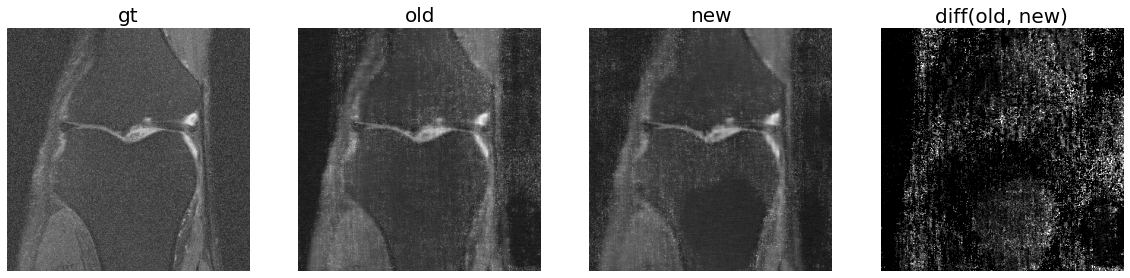

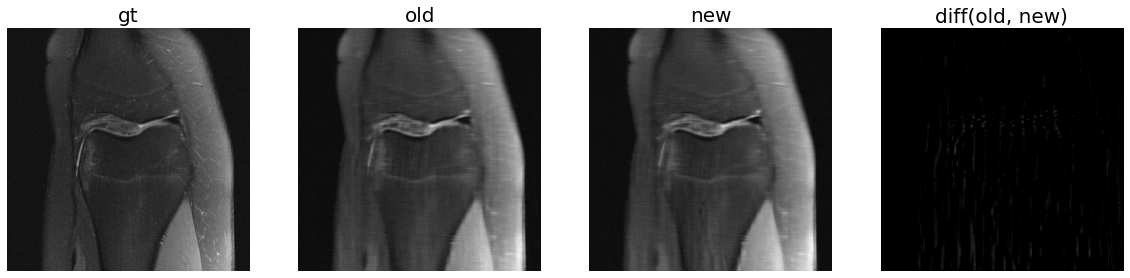

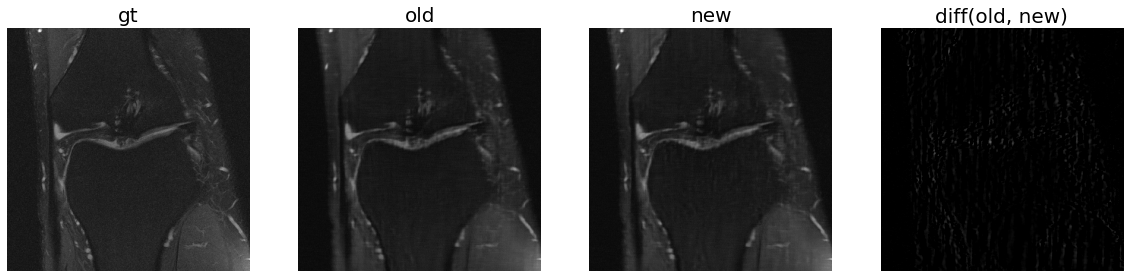

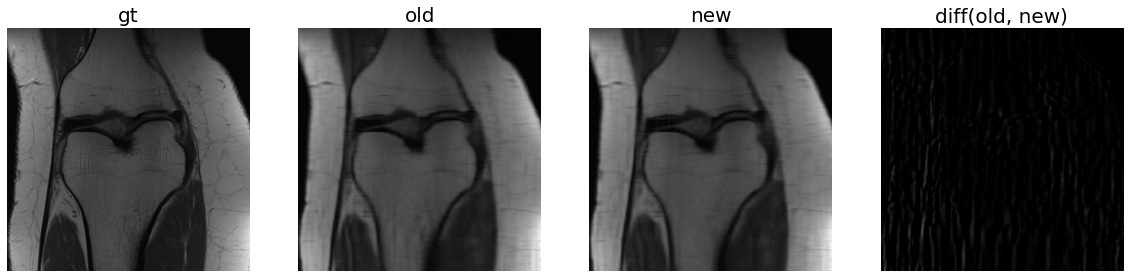

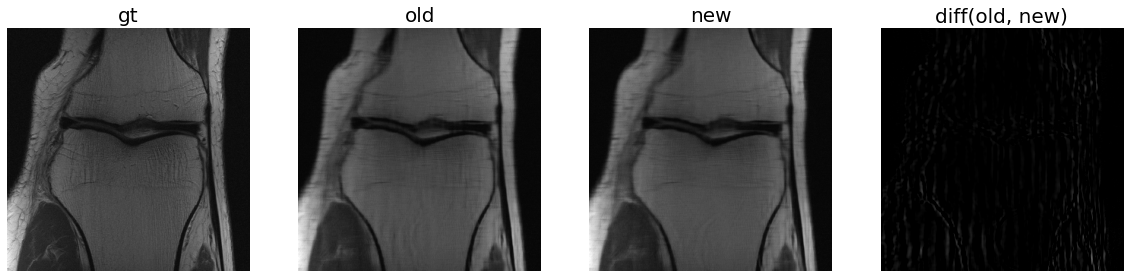

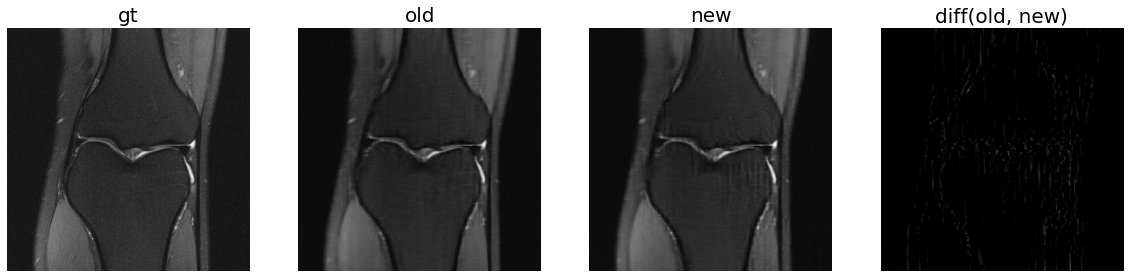

In [16]:
title_list = ['gt', 'old', 'new', 'diff(old, new)']

for s in im_list:    
    plot_list(s, title_list, clim=(0,1))

### test old/new pytorch models. are they the same?

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import PIL
from copy import copy
from torch.autograd import Variable

In [47]:
def add_module(self, module):
    self.add_module(str(len(self) + 1), module)

torch.nn.Module.add = add_module

class Conv_Model_Old(nn.Module):
    def __init__(self, num_layers, strides, num_channels, out_depth, hidden_size, upsample_mode, act_fun, bn_affine=True, bias=False, need_last=False, kernel_size=3):
        super(Conv_Model_Old, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.upsample_mode = upsample_mode
        self.act_fun = act_fun
        self.layer_inds = [] # record index of the layers that generate output in the sequential mode (after each BatchNorm)
        self.combinations = None # this holds input of the last layer which is upsampled versions of previous layers
        #self.dtype = dtype

        cntr = 1
        #torch.set_default_tensor_type(dtype)
        net1 = nn.Sequential()
        for i in range(num_layers-1):

            net1.add(nn.Upsample(size=hidden_size[i], mode=upsample_mode))#,align_corners=True))
            cntr += 1

            conv = nn.Conv2d(num_channels, num_channels, kernel_size, strides[i], padding=(kernel_size-1)//2, bias=bias)
            net1.add(conv)
            cntr += 1

            net1.add(act_fun)
            cntr += 1

            net1.add(nn.BatchNorm2d( num_channels, affine=bn_affine))
            if i != num_layers - 2: # penultimate layer will automatically be concatenated if skip connection option is chosen
                self.layer_inds.append(cntr)
            cntr += 1

        net2 = nn.Sequential()

        nic = num_channels

        if need_last: # orignal code default False, but we call it True
            net2.add( nn.Conv2d(nic, num_channels, kernel_size, strides[i], padding=(kernel_size-1)//2, bias=bias) )
            net2.add(act_fun)
            net2.add(nn.BatchNorm2d( num_channels, affine=bn_affine))
            nic = num_channels

        net2.add(nn.Conv2d(nic, out_depth, 1, 1, padding=0, bias=bias))

        self.net1 = net1 # actual convdecoder network
        self.net2 = net2 # (default seting) one-layer net converting number of channels

    def forward(self, x, scale_out=1):
        ''' run input thru net1 (convdecoder) then net2 (converts number of channels
        provide options for skip connections (default False) and scaling factors (default 1) '''
        out1 = self.net1(x)
        self.combinations = copy(out1)
        out2 = self.net2(out1)
        return out2*scale_out
    def up_sample(self,img):
        ''' single upsampling layer '''
        samp_block = nn.Upsample(size=self.hidden_size[-1], mode=self.upsample_mode)#,align_corners=True)
        img = samp_block(img)
        return img

In [28]:
class Conv_Model_New(nn.Module):
    def __init__(self, num_layers, num_channels, out_depth, hidden_size,
                 upsample_mode='nearest', kernel_size=3, bias=False):

        super(Conv_Model_New, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.upsample_mode = upsample_mode

        # define layer types
        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size, \
                         stride=1, padding=1, bias=bias)
        self.bn = nn.BatchNorm2d(num_channels, affine=True)
        self.collapse_channels = nn.Conv2d(num_channels, out_depth, 1, 1, padding=0, bias=bias)

        self.upsamp_list = []
        for size in hidden_size:
            self.upsamp_list.append(nn.Upsample(size=size, mode=upsample_mode))

    def forward(self, x):
        ''' run input thru net1 (convdecoder) then net2 (converts number of channels)
        provide options for skip connections (default False) and scaling factors (default 1) '''

        feat_maps = []

        for upsamp in self.upsamp_list:
            x = self.bn(F.relu(self.conv(upsamp(x))))
            feat_maps.append(self.collapse_channels(x)[0])

        # last layer: collapse channels, don't upsample
        x = self.collapse_channels(self.bn(F.relu(self.conv(x))))

        return x, feat_maps

In [60]:
torch.manual_seed(0)
np.random.seed(0)

num_channels = 5
num_layers = 2

input_shape = [1, num_channels, 2, 1]
ni = Variable(torch.zeros(input_shape))
ni.data.uniform_()
hidden_size = [(4,2), (6, 4)]#, (8, 6)]

In [63]:
torch.manual_seed(0)
np.random.seed(0)
net_new = Conv_Model_New(num_layers=2, num_channels=num_channels, out_depth=1, hidden_size=hidden_size)

out_new = net_new(ni)
out_new

(tensor([[[[ 0.7736,  0.2143,  0.1138, -0.2293],
           [-0.2268, -0.9152, -0.9586, -0.6146],
           [ 0.4019, -0.3244, -0.4895,  0.0858],
           [ 0.3852, -0.4817,  0.0160,  0.8050],
           [ 0.3078,  0.0252, -0.2495,  0.2854],
           [-0.3345,  0.7217,  0.3585,  0.3299]]]],
        grad_fn=<ThnnConv2DBackward>),
 [tensor([[[ 0.2475,  0.3068],
           [ 0.1716, -0.1053],
           [ 0.1496, -0.1819],
           [-0.3327, -0.2555]]], grad_fn=<SelectBackward>),
  tensor([[[-0.3371, -0.5027, -0.8049,  0.0043],
           [-0.1716, -0.1495,  0.2356,  0.7366],
           [-0.0703,  0.0661,  0.3059,  0.4255],
           [-0.1394, -0.5334, -0.1745,  0.4982],
           [-0.5149, -0.7368,  0.4450,  0.5200],
           [-0.0871,  0.3426,  0.3426,  0.2996]]], grad_fn=<SelectBackward>)])

In [64]:
strides = [1]*(2) # [1] * (num_layers-1)

torch.manual_seed(0)
np.random.seed(0)
net_old = Conv_Model_Old(num_layers=num_layers, strides=strides, num_channels=num_channels, out_depth=1, \
                         hidden_size=hidden_size, \
                         upsample_mode='nearest', act_fun=nn.ReLU(), bn_affine=True, \
                         bias=False, need_last=True, kernel_size=3)
out_old = net_old(ni)
out_old

tensor([[[[ 0.6651, -0.2414],
          [ 0.1701, -0.5797],
          [ 0.0804,  0.6208],
          [-0.8355,  0.1201]]]], grad_fn=<MulBackward0>)